# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
#data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

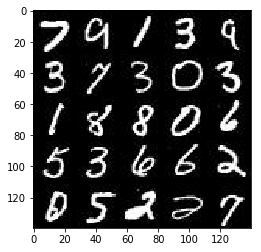

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

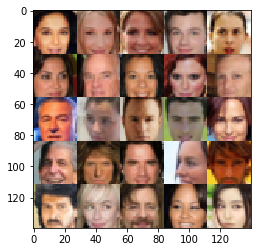

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    
    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    in_learning_rate = tf.placeholder(tf.float32, None, name='learning_rate')
    
    return input_real, input_z, in_learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    
    alpha=0.2
    
    with tf.variable_scope("discriminator", reuse=reuse):
    
        # input images 28*28*3
        h1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        lrelu1 = tf.maximum(alpha * h1, h1)
        
        
        h2 = tf.layers.conv2d(lrelu1, 128, 5, strides=1, padding="same",
                              kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn2 = tf.layers.batch_normalization(h2, training=True)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
        
        
        h3 = tf.layers.conv2d(lrelu2, 256, 5, strides=2, padding="same", 
                             kernel_initializer = tf.random_normal_initializer(stddev=0.02))
        bn3 = tf.layers.batch_normalization(h3, training=True)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
        
        # flatten it
        flat = tf.reshape(lrelu3, (-1, 7*7*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)

        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Implement Function
    
    alpha = 0.2
    
    with tf.variable_scope('generator', reuse=not is_train):
        # Input z
        h1 = tf.layers.dense(z, 7*7*256)
        
        # reshape 
        h1 = tf.reshape(h1, (-1, 7, 7, 256))
        bn1 = tf.layers.batch_normalization(h1, training=is_train)
        lrelu1 = tf.maximum(alpha * bn1, bn1)
        
        
        h2 = tf.layers.conv2d_transpose(lrelu1, 128, 5, strides=1, padding="SAME")
        bn2 = tf.layers.batch_normalization(h2, training=is_train)
        lrelu2 = tf.maximum(alpha * bn2, bn2)
       
        
        h3 = tf.layers.conv2d_transpose(lrelu2, 64, 5, strides=2, padding='SAME')
        bn3 = tf.layers.batch_normalization(h3, training=is_train)
        lrelu3 = tf.maximum(alpha * bn3, bn3)
       
        
        logits = tf.layers.conv2d_transpose(lrelu3, out_channel_dim, 5, strides=2, padding="SAME")
        
        out = tf.tanh(logits)
       
        
        return out



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

        return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    
    _, image_width, image_height, image_channels = data_shape
    
    input_real, input_z, _learning_rate = model_inputs(image_width, image_height, image_channels, z_dim)
    
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    
    d_train_opt, g_train_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    
    n_images = 25
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                batch_images = batch_images*2.0
                #print(batch_images[0])
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_train_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                steps += 1

                # Print the d_train_loss and g_train_loss
                if (steps % 10 == 0):
                    train_loss_d = sess.run(d_loss, {input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))   
                    
                # Print the generator output
                if (steps % 100 == 0):
                    show_generator_output(sess, n_images, input_z, image_channels, data_image_mode)
                
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3274... Generator Loss: 1.5188
Epoch 1/2... Discriminator Loss: 0.1219... Generator Loss: 3.1872
Epoch 1/2... Discriminator Loss: 2.4487... Generator Loss: 0.2123
Epoch 1/2... Discriminator Loss: 0.9831... Generator Loss: 0.8091
Epoch 1/2... Discriminator Loss: 2.6821... Generator Loss: 5.6556
Epoch 1/2... Discriminator Loss: 0.6803... Generator Loss: 1.5258
Epoch 1/2... Discriminator Loss: 0.3261... Generator Loss: 2.4089
Epoch 1/2... Discriminator Loss: 0.7460... Generator Loss: 1.2044
Epoch 1/2... Discriminator Loss: 0.4283... Generator Loss: 1.7831
Epoch 1/2... Discriminator Loss: 1.1426... Generator Loss: 0.4671


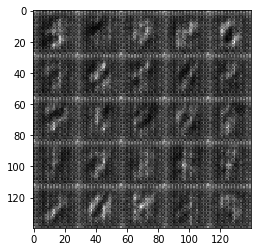

Epoch 1/2... Discriminator Loss: 0.4856... Generator Loss: 1.9684
Epoch 1/2... Discriminator Loss: 0.6463... Generator Loss: 1.0488
Epoch 1/2... Discriminator Loss: 0.5588... Generator Loss: 2.2480
Epoch 1/2... Discriminator Loss: 0.5911... Generator Loss: 2.7381
Epoch 1/2... Discriminator Loss: 0.4199... Generator Loss: 1.7930
Epoch 1/2... Discriminator Loss: 0.9626... Generator Loss: 3.0668
Epoch 1/2... Discriminator Loss: 0.6046... Generator Loss: 2.3259
Epoch 1/2... Discriminator Loss: 0.4416... Generator Loss: 1.4882
Epoch 1/2... Discriminator Loss: 0.4760... Generator Loss: 1.3071
Epoch 1/2... Discriminator Loss: 0.4360... Generator Loss: 2.0074


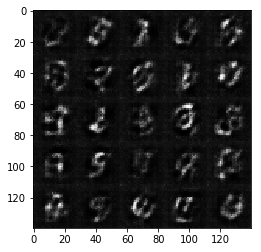

Epoch 1/2... Discriminator Loss: 0.5287... Generator Loss: 1.2663
Epoch 1/2... Discriminator Loss: 0.4624... Generator Loss: 1.4141
Epoch 1/2... Discriminator Loss: 1.2862... Generator Loss: 4.1855
Epoch 1/2... Discriminator Loss: 0.4127... Generator Loss: 1.9230
Epoch 1/2... Discriminator Loss: 0.5544... Generator Loss: 1.2105
Epoch 1/2... Discriminator Loss: 0.4275... Generator Loss: 1.5977
Epoch 1/2... Discriminator Loss: 0.4068... Generator Loss: 1.5070
Epoch 1/2... Discriminator Loss: 0.5707... Generator Loss: 1.5867
Epoch 1/2... Discriminator Loss: 0.4044... Generator Loss: 1.5506
Epoch 1/2... Discriminator Loss: 0.6902... Generator Loss: 0.8675


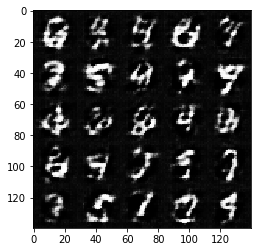

Epoch 1/2... Discriminator Loss: 0.5631... Generator Loss: 2.5810
Epoch 1/2... Discriminator Loss: 0.6475... Generator Loss: 1.0206
Epoch 1/2... Discriminator Loss: 0.3930... Generator Loss: 1.6786
Epoch 1/2... Discriminator Loss: 1.0438... Generator Loss: 0.5150
Epoch 1/2... Discriminator Loss: 0.4386... Generator Loss: 1.6208
Epoch 1/2... Discriminator Loss: 0.3413... Generator Loss: 1.7956
Epoch 1/2... Discriminator Loss: 0.3130... Generator Loss: 2.3357
Epoch 1/2... Discriminator Loss: 0.4771... Generator Loss: 1.3188
Epoch 1/2... Discriminator Loss: 0.5894... Generator Loss: 2.5005
Epoch 1/2... Discriminator Loss: 0.7385... Generator Loss: 1.1261


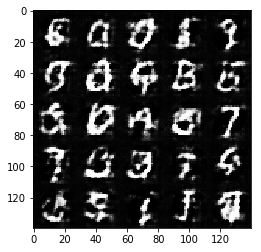

Epoch 1/2... Discriminator Loss: 0.3679... Generator Loss: 1.5957
Epoch 1/2... Discriminator Loss: 0.4565... Generator Loss: 1.4979
Epoch 1/2... Discriminator Loss: 0.9700... Generator Loss: 0.6175
Epoch 1/2... Discriminator Loss: 0.5151... Generator Loss: 1.3116
Epoch 1/2... Discriminator Loss: 0.7465... Generator Loss: 0.8247
Epoch 1/2... Discriminator Loss: 0.7052... Generator Loss: 0.8473
Epoch 1/2... Discriminator Loss: 3.0495... Generator Loss: 6.3859
Epoch 1/2... Discriminator Loss: 0.5625... Generator Loss: 1.6474
Epoch 1/2... Discriminator Loss: 0.4907... Generator Loss: 1.3122
Epoch 1/2... Discriminator Loss: 0.4456... Generator Loss: 1.9460


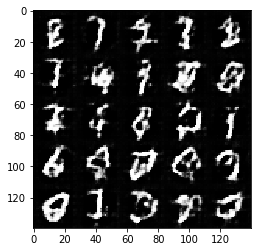

Epoch 1/2... Discriminator Loss: 0.5312... Generator Loss: 1.6812
Epoch 1/2... Discriminator Loss: 0.3635... Generator Loss: 2.0473
Epoch 1/2... Discriminator Loss: 0.5640... Generator Loss: 1.1377
Epoch 1/2... Discriminator Loss: 0.8533... Generator Loss: 0.7162
Epoch 1/2... Discriminator Loss: 0.9202... Generator Loss: 0.6899
Epoch 1/2... Discriminator Loss: 0.6425... Generator Loss: 1.1381
Epoch 1/2... Discriminator Loss: 0.4735... Generator Loss: 1.4635
Epoch 1/2... Discriminator Loss: 0.4919... Generator Loss: 1.4205
Epoch 1/2... Discriminator Loss: 0.9895... Generator Loss: 1.6170
Epoch 1/2... Discriminator Loss: 0.8735... Generator Loss: 0.7446


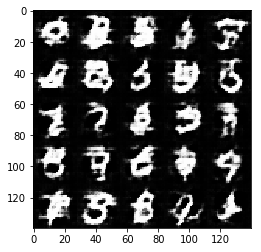

Epoch 1/2... Discriminator Loss: 0.6226... Generator Loss: 1.1063
Epoch 1/2... Discriminator Loss: 0.6663... Generator Loss: 0.9722
Epoch 1/2... Discriminator Loss: 0.5510... Generator Loss: 1.2879
Epoch 1/2... Discriminator Loss: 0.5744... Generator Loss: 1.0979
Epoch 1/2... Discriminator Loss: 0.6954... Generator Loss: 0.8928
Epoch 1/2... Discriminator Loss: 0.6774... Generator Loss: 2.6801
Epoch 1/2... Discriminator Loss: 1.4185... Generator Loss: 3.4098
Epoch 1/2... Discriminator Loss: 0.8223... Generator Loss: 1.1592
Epoch 1/2... Discriminator Loss: 0.7166... Generator Loss: 1.1954
Epoch 1/2... Discriminator Loss: 0.6365... Generator Loss: 1.2259


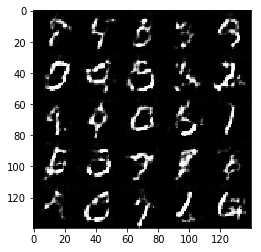

Epoch 1/2... Discriminator Loss: 0.8513... Generator Loss: 0.7233
Epoch 1/2... Discriminator Loss: 0.5403... Generator Loss: 1.3702
Epoch 1/2... Discriminator Loss: 0.6718... Generator Loss: 1.0817
Epoch 1/2... Discriminator Loss: 0.5575... Generator Loss: 1.0939
Epoch 1/2... Discriminator Loss: 0.5313... Generator Loss: 1.2963
Epoch 1/2... Discriminator Loss: 1.3559... Generator Loss: 2.9816
Epoch 1/2... Discriminator Loss: 1.1137... Generator Loss: 0.5643
Epoch 1/2... Discriminator Loss: 0.7651... Generator Loss: 1.4055
Epoch 1/2... Discriminator Loss: 1.0348... Generator Loss: 0.6094
Epoch 1/2... Discriminator Loss: 0.9543... Generator Loss: 2.3682


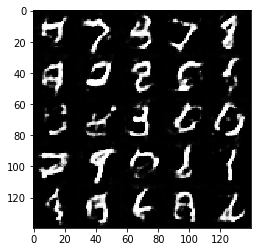

Epoch 1/2... Discriminator Loss: 0.5715... Generator Loss: 1.3758
Epoch 1/2... Discriminator Loss: 0.5214... Generator Loss: 1.1963
Epoch 1/2... Discriminator Loss: 0.4676... Generator Loss: 1.4420
Epoch 1/2... Discriminator Loss: 0.5961... Generator Loss: 1.1151
Epoch 1/2... Discriminator Loss: 0.4343... Generator Loss: 1.4847
Epoch 1/2... Discriminator Loss: 0.6512... Generator Loss: 0.9573
Epoch 1/2... Discriminator Loss: 0.5306... Generator Loss: 1.1597
Epoch 1/2... Discriminator Loss: 3.0364... Generator Loss: 4.1435
Epoch 1/2... Discriminator Loss: 0.9526... Generator Loss: 0.8109
Epoch 1/2... Discriminator Loss: 0.9098... Generator Loss: 1.4234


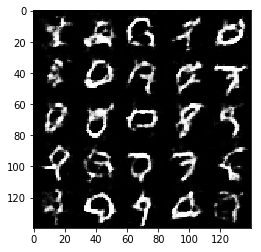

Epoch 1/2... Discriminator Loss: 1.3262... Generator Loss: 0.8048
Epoch 1/2... Discriminator Loss: 0.7588... Generator Loss: 1.1209
Epoch 1/2... Discriminator Loss: 0.7431... Generator Loss: 0.8297
Epoch 2/2... Discriminator Loss: 0.5254... Generator Loss: 1.3330
Epoch 2/2... Discriminator Loss: 0.5004... Generator Loss: 1.5799
Epoch 2/2... Discriminator Loss: 0.5667... Generator Loss: 1.1741
Epoch 2/2... Discriminator Loss: 0.4633... Generator Loss: 1.4564
Epoch 2/2... Discriminator Loss: 0.4190... Generator Loss: 1.3590
Epoch 2/2... Discriminator Loss: 0.4835... Generator Loss: 2.0494
Epoch 2/2... Discriminator Loss: 0.5660... Generator Loss: 1.0788


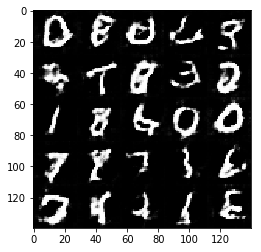

Epoch 2/2... Discriminator Loss: 0.4742... Generator Loss: 3.1358
Epoch 2/2... Discriminator Loss: 0.8345... Generator Loss: 1.6315
Epoch 2/2... Discriminator Loss: 1.2657... Generator Loss: 2.1287
Epoch 2/2... Discriminator Loss: 0.9073... Generator Loss: 1.0664
Epoch 2/2... Discriminator Loss: 1.2242... Generator Loss: 0.4951
Epoch 2/2... Discriminator Loss: 0.8140... Generator Loss: 0.9218
Epoch 2/2... Discriminator Loss: 0.8128... Generator Loss: 1.3619
Epoch 2/2... Discriminator Loss: 0.4853... Generator Loss: 1.6957
Epoch 2/2... Discriminator Loss: 0.6873... Generator Loss: 0.8388
Epoch 2/2... Discriminator Loss: 0.6883... Generator Loss: 0.9546


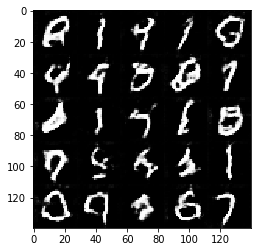

Epoch 2/2... Discriminator Loss: 0.5192... Generator Loss: 1.2560
Epoch 2/2... Discriminator Loss: 0.5952... Generator Loss: 1.0540
Epoch 2/2... Discriminator Loss: 0.6923... Generator Loss: 0.8994
Epoch 2/2... Discriminator Loss: 2.6354... Generator Loss: 3.9229
Epoch 2/2... Discriminator Loss: 1.3410... Generator Loss: 2.1689
Epoch 2/2... Discriminator Loss: 1.0460... Generator Loss: 2.1324
Epoch 2/2... Discriminator Loss: 0.9240... Generator Loss: 1.7042
Epoch 2/2... Discriminator Loss: 0.7336... Generator Loss: 1.7667
Epoch 2/2... Discriminator Loss: 0.6921... Generator Loss: 0.9293
Epoch 2/2... Discriminator Loss: 0.5324... Generator Loss: 1.3307


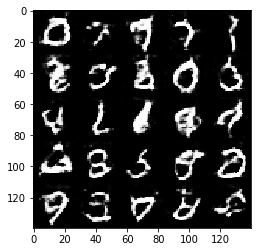

Epoch 2/2... Discriminator Loss: 0.5820... Generator Loss: 1.0370
Epoch 2/2... Discriminator Loss: 0.5019... Generator Loss: 1.3658
Epoch 2/2... Discriminator Loss: 0.6577... Generator Loss: 1.0605
Epoch 2/2... Discriminator Loss: 0.5978... Generator Loss: 1.1034
Epoch 2/2... Discriminator Loss: 0.6243... Generator Loss: 1.0554
Epoch 2/2... Discriminator Loss: 1.0500... Generator Loss: 0.6110
Epoch 2/2... Discriminator Loss: 0.8759... Generator Loss: 0.6873
Epoch 2/2... Discriminator Loss: 1.6328... Generator Loss: 0.2779
Epoch 2/2... Discriminator Loss: 1.3653... Generator Loss: 0.4483
Epoch 2/2... Discriminator Loss: 0.6111... Generator Loss: 1.2822


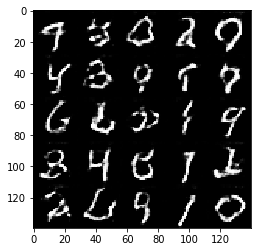

Epoch 2/2... Discriminator Loss: 0.5356... Generator Loss: 1.2557
Epoch 2/2... Discriminator Loss: 0.4146... Generator Loss: 1.5870
Epoch 2/2... Discriminator Loss: 1.3178... Generator Loss: 0.4883
Epoch 2/2... Discriminator Loss: 1.0273... Generator Loss: 1.6655
Epoch 2/2... Discriminator Loss: 0.8572... Generator Loss: 1.6844
Epoch 2/2... Discriminator Loss: 0.8943... Generator Loss: 0.8684
Epoch 2/2... Discriminator Loss: 0.8105... Generator Loss: 0.8854
Epoch 2/2... Discriminator Loss: 0.7369... Generator Loss: 1.5709
Epoch 2/2... Discriminator Loss: 0.8070... Generator Loss: 0.7933
Epoch 2/2... Discriminator Loss: 0.5995... Generator Loss: 1.1525


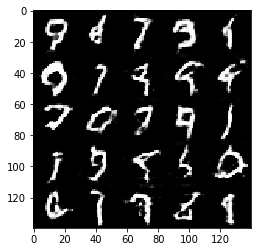

Epoch 2/2... Discriminator Loss: 0.4290... Generator Loss: 1.3743
Epoch 2/2... Discriminator Loss: 0.4134... Generator Loss: 1.5126
Epoch 2/2... Discriminator Loss: 1.0526... Generator Loss: 0.5844
Epoch 2/2... Discriminator Loss: 0.9623... Generator Loss: 1.3266
Epoch 2/2... Discriminator Loss: 0.7219... Generator Loss: 1.3367
Epoch 2/2... Discriminator Loss: 0.7798... Generator Loss: 0.9360
Epoch 2/2... Discriminator Loss: 0.7861... Generator Loss: 0.9599
Epoch 2/2... Discriminator Loss: 0.7915... Generator Loss: 2.0672
Epoch 2/2... Discriminator Loss: 1.0780... Generator Loss: 2.2099
Epoch 2/2... Discriminator Loss: 0.4769... Generator Loss: 1.5043


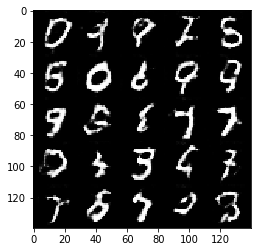

Epoch 2/2... Discriminator Loss: 0.6214... Generator Loss: 1.0867
Epoch 2/2... Discriminator Loss: 0.9845... Generator Loss: 0.6027
Epoch 2/2... Discriminator Loss: 0.6918... Generator Loss: 0.8780
Epoch 2/2... Discriminator Loss: 2.0697... Generator Loss: 0.1773
Epoch 2/2... Discriminator Loss: 1.0053... Generator Loss: 0.7774
Epoch 2/2... Discriminator Loss: 1.3344... Generator Loss: 0.4268
Epoch 2/2... Discriminator Loss: 0.8066... Generator Loss: 2.0588
Epoch 2/2... Discriminator Loss: 0.5953... Generator Loss: 1.2212
Epoch 2/2... Discriminator Loss: 0.6358... Generator Loss: 1.0467
Epoch 2/2... Discriminator Loss: 0.6669... Generator Loss: 1.0026


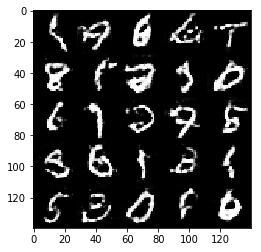

Epoch 2/2... Discriminator Loss: 0.6723... Generator Loss: 0.9985
Epoch 2/2... Discriminator Loss: 0.5922... Generator Loss: 1.1089
Epoch 2/2... Discriminator Loss: 0.8730... Generator Loss: 1.0747
Epoch 2/2... Discriminator Loss: 0.5670... Generator Loss: 1.7692
Epoch 2/2... Discriminator Loss: 0.6597... Generator Loss: 1.2632
Epoch 2/2... Discriminator Loss: 0.6433... Generator Loss: 1.0375
Epoch 2/2... Discriminator Loss: 0.8879... Generator Loss: 0.6977
Epoch 2/2... Discriminator Loss: 0.5229... Generator Loss: 1.5930
Epoch 2/2... Discriminator Loss: 0.7926... Generator Loss: 1.8544
Epoch 2/2... Discriminator Loss: 0.5197... Generator Loss: 1.7915


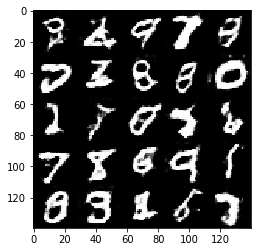

Epoch 2/2... Discriminator Loss: 0.7574... Generator Loss: 0.9610
Epoch 2/2... Discriminator Loss: 0.5100... Generator Loss: 1.5254
Epoch 2/2... Discriminator Loss: 0.6896... Generator Loss: 0.9568
Epoch 2/2... Discriminator Loss: 5.6387... Generator Loss: 7.7169
Epoch 2/2... Discriminator Loss: 0.9790... Generator Loss: 0.6875
Epoch 2/2... Discriminator Loss: 0.6126... Generator Loss: 1.5094
Epoch 2/2... Discriminator Loss: 0.4906... Generator Loss: 1.8190
Epoch 2/2... Discriminator Loss: 0.6302... Generator Loss: 1.1401
Epoch 2/2... Discriminator Loss: 0.6793... Generator Loss: 1.0718
Epoch 2/2... Discriminator Loss: 0.7198... Generator Loss: 0.9161


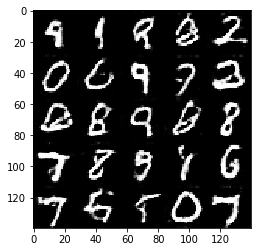

Epoch 2/2... Discriminator Loss: 0.4865... Generator Loss: 1.2744
Epoch 2/2... Discriminator Loss: 0.7692... Generator Loss: 1.0825
Epoch 2/2... Discriminator Loss: 0.5894... Generator Loss: 1.9178
Epoch 2/2... Discriminator Loss: 0.6259... Generator Loss: 1.2432
Epoch 2/2... Discriminator Loss: 0.8041... Generator Loss: 0.8351
Epoch 2/2... Discriminator Loss: 0.7156... Generator Loss: 1.0326
Epoch 2/2... Discriminator Loss: 0.5494... Generator Loss: 1.6368


In [12]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.4942... Generator Loss: 1.4942
Epoch 1/1... Discriminator Loss: 0.3712... Generator Loss: 1.6155
Epoch 1/1... Discriminator Loss: 0.2626... Generator Loss: 2.0625
Epoch 1/1... Discriminator Loss: 0.2257... Generator Loss: 2.2618
Epoch 1/1... Discriminator Loss: 0.1513... Generator Loss: 2.5741
Epoch 1/1... Discriminator Loss: 0.1209... Generator Loss: 2.9379
Epoch 1/1... Discriminator Loss: 0.1332... Generator Loss: 2.8510
Epoch 1/1... Discriminator Loss: 1.0233... Generator Loss: 8.2622
Epoch 1/1... Discriminator Loss: 0.7495... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 0.3990... Generator Loss: 3.0850


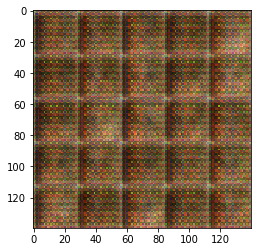

Epoch 1/1... Discriminator Loss: 0.2862... Generator Loss: 3.9325
Epoch 1/1... Discriminator Loss: 1.7469... Generator Loss: 0.2423
Epoch 1/1... Discriminator Loss: 0.6854... Generator Loss: 1.3488
Epoch 1/1... Discriminator Loss: 0.4835... Generator Loss: 1.7972
Epoch 1/1... Discriminator Loss: 0.4403... Generator Loss: 2.9932
Epoch 1/1... Discriminator Loss: 0.3464... Generator Loss: 2.0382
Epoch 1/1... Discriminator Loss: 0.4016... Generator Loss: 1.8217
Epoch 1/1... Discriminator Loss: 0.3534... Generator Loss: 2.1138
Epoch 1/1... Discriminator Loss: 0.4821... Generator Loss: 1.3577
Epoch 1/1... Discriminator Loss: 0.3697... Generator Loss: 2.7660


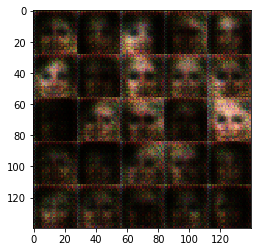

Epoch 1/1... Discriminator Loss: 0.6869... Generator Loss: 1.0612
Epoch 1/1... Discriminator Loss: 0.6086... Generator Loss: 1.1893
Epoch 1/1... Discriminator Loss: 0.5512... Generator Loss: 1.9500
Epoch 1/1... Discriminator Loss: 0.3698... Generator Loss: 2.8307
Epoch 1/1... Discriminator Loss: 1.2318... Generator Loss: 5.6790
Epoch 1/1... Discriminator Loss: 0.5602... Generator Loss: 1.3571
Epoch 1/1... Discriminator Loss: 1.2636... Generator Loss: 4.9367
Epoch 1/1... Discriminator Loss: 1.2756... Generator Loss: 4.8177
Epoch 1/1... Discriminator Loss: 0.3847... Generator Loss: 2.5821
Epoch 1/1... Discriminator Loss: 1.0258... Generator Loss: 0.6735


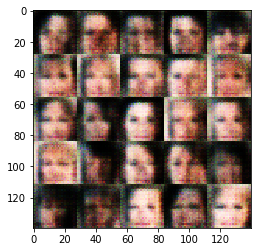

Epoch 1/1... Discriminator Loss: 0.5770... Generator Loss: 2.3180
Epoch 1/1... Discriminator Loss: 0.7475... Generator Loss: 3.2239
Epoch 1/1... Discriminator Loss: 0.6336... Generator Loss: 1.1668
Epoch 1/1... Discriminator Loss: 0.9844... Generator Loss: 0.6676
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 1.4202
Epoch 1/1... Discriminator Loss: 0.6566... Generator Loss: 2.1540
Epoch 1/1... Discriminator Loss: 0.6413... Generator Loss: 1.3992
Epoch 1/1... Discriminator Loss: 0.3713... Generator Loss: 2.0475
Epoch 1/1... Discriminator Loss: 0.5228... Generator Loss: 2.2364
Epoch 1/1... Discriminator Loss: 0.4466... Generator Loss: 2.3194


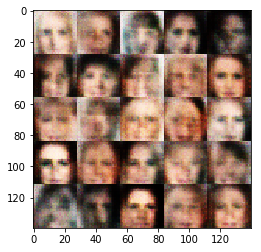

Epoch 1/1... Discriminator Loss: 0.5759... Generator Loss: 1.4577
Epoch 1/1... Discriminator Loss: 0.4110... Generator Loss: 2.0875
Epoch 1/1... Discriminator Loss: 0.5215... Generator Loss: 1.8713
Epoch 1/1... Discriminator Loss: 0.5486... Generator Loss: 1.7411
Epoch 1/1... Discriminator Loss: 0.6889... Generator Loss: 3.2861
Epoch 1/1... Discriminator Loss: 0.5102... Generator Loss: 1.9924
Epoch 1/1... Discriminator Loss: 0.5009... Generator Loss: 1.4494
Epoch 1/1... Discriminator Loss: 0.9042... Generator Loss: 0.7414
Epoch 1/1... Discriminator Loss: 0.8012... Generator Loss: 0.9260
Epoch 1/1... Discriminator Loss: 0.6077... Generator Loss: 1.4967


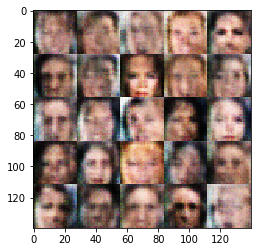

Epoch 1/1... Discriminator Loss: 0.4938... Generator Loss: 1.4904
Epoch 1/1... Discriminator Loss: 0.5600... Generator Loss: 1.2340
Epoch 1/1... Discriminator Loss: 0.8569... Generator Loss: 0.9397
Epoch 1/1... Discriminator Loss: 0.6920... Generator Loss: 1.6887
Epoch 1/1... Discriminator Loss: 0.6689... Generator Loss: 1.3530
Epoch 1/1... Discriminator Loss: 0.5380... Generator Loss: 1.7866
Epoch 1/1... Discriminator Loss: 0.6415... Generator Loss: 2.0963
Epoch 1/1... Discriminator Loss: 0.6860... Generator Loss: 1.0777
Epoch 1/1... Discriminator Loss: 0.6349... Generator Loss: 1.4363
Epoch 1/1... Discriminator Loss: 1.2538... Generator Loss: 3.2213


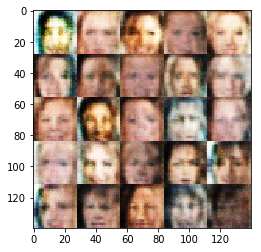

Epoch 1/1... Discriminator Loss: 0.9256... Generator Loss: 2.0180
Epoch 1/1... Discriminator Loss: 0.7816... Generator Loss: 1.0178
Epoch 1/1... Discriminator Loss: 0.7383... Generator Loss: 1.2035
Epoch 1/1... Discriminator Loss: 1.3828... Generator Loss: 3.4943
Epoch 1/1... Discriminator Loss: 0.8432... Generator Loss: 1.2244
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 1.8477
Epoch 1/1... Discriminator Loss: 0.9431... Generator Loss: 0.7830
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.4562
Epoch 1/1... Discriminator Loss: 0.8883... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 0.8673


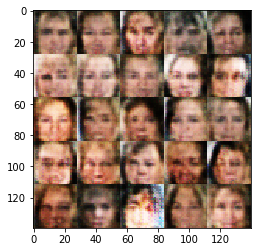

Epoch 1/1... Discriminator Loss: 0.9123... Generator Loss: 2.1568
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.6215
Epoch 1/1... Discriminator Loss: 0.8507... Generator Loss: 1.8888
Epoch 1/1... Discriminator Loss: 0.7679... Generator Loss: 1.4573
Epoch 1/1... Discriminator Loss: 0.7646... Generator Loss: 1.3101
Epoch 1/1... Discriminator Loss: 0.8577... Generator Loss: 2.0360
Epoch 1/1... Discriminator Loss: 0.7973... Generator Loss: 2.3275
Epoch 1/1... Discriminator Loss: 0.8430... Generator Loss: 2.2302
Epoch 1/1... Discriminator Loss: 0.8013... Generator Loss: 1.5987
Epoch 1/1... Discriminator Loss: 1.3009... Generator Loss: 2.6491


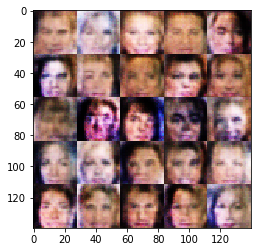

KeyboardInterrupt: 

In [13]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.